In [1]:
import pandas as pd
import numpy as np
import sns as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.core.display import display
from costcla import BayesMinimumRiskClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix,  classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.preprocessing import StandardScaler
from costcla.sampling import cost_sampling, undersampling
import seaborn as sns
sns.set_context('talk')

In [2]:
data = pd.read_csv("data/fetal_health.csv")

# Split df into X and y
y = data['fetal_health']
X = data.drop('fetal_health', axis=1)
# print(data.describe())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, stratify=y, random_state=2)

# StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [9]:
import pandas as pd
import numpy as np
import sns as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.core.display import display
from costcla import BayesMinimumRiskClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix,  classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.preprocessing import StandardScaler
from costcla.sampling import cost_sampling, undersampling
import seaborn as sns
sns.set_context('talk')



def printCfm(df_cfm):
    # df_cfm = pd.DataFrame(cfm)
    # plt.figure(figsize=(10, 7))
    sns.heatmap(df_cfm, annot=True, fmt="d")
    # cfm_plot.figure.savefig("cfm.png")
    # df_cm = pd.DataFrame(df_cfm, range(3), range(3))
    # sns.set(font_scale=1.4)
    # # fig, ax = plt.subplots(figsize=(11, 8))
    # sns.heatmap(df_cm, annot=True, annot_kws={"size": 15})
    plt.show()

    return

In [10]:
def cost_scores(y_pred, y_test):
    
    printCfm(confusion_matrix(y_test, y_pred))
    conf_m = confusion_matrix(y_test, y_pred).T
    cost_m = [[0, 4, 5], [1, 0, 1], [1, 1, 0]]
    loss   = np.sum(conf_m * np.array(cost_m))

    print(conf_m)
    print(classification_report(y_test, y_pred))

    return loss


/Users/conatseche/PycharmProjects/pythonProject1/venv/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


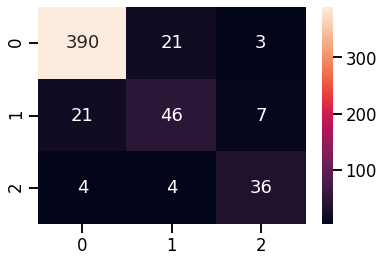

[[390  21   4]
 [ 21  46   4]
 [  3   7  36]]
              precision    recall  f1-score   support

         1.0       0.94      0.94      0.94       414
         2.0       0.65      0.62      0.63        74
         3.0       0.78      0.82      0.80        44

    accuracy                           0.89       532
   macro avg       0.79      0.79      0.79       532
weighted avg       0.89      0.89      0.89       532

SVC loss: 139


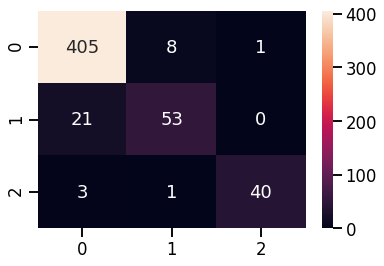

[[405  21   3]
 [  8  53   1]
 [  1   0  40]]
              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96       414
         2.0       0.85      0.72      0.78        74
         3.0       0.98      0.91      0.94        44

    accuracy                           0.94       532
   macro avg       0.92      0.87      0.89       532
weighted avg       0.93      0.94      0.93       532

Random Forest loss: 109


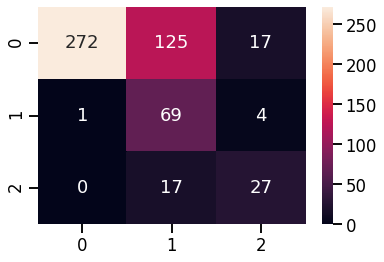

[[272   1   0]
 [125  69  17]
 [ 17   4  27]]
              precision    recall  f1-score   support

         1.0       1.00      0.66      0.79       414
         2.0       0.33      0.93      0.48        74
         3.0       0.56      0.61      0.59        44

    accuracy                           0.69       532
   macro avg       0.63      0.73      0.62       532
weighted avg       0.87      0.69      0.73       532

Naive Bayes loss: 167
[139, 109, 167]


In [11]:
ret_loss = []

svc_model = LinearSVC(random_state=0).fit(X_train, y_train)
y_pred = svc_model.predict(X_test)
loss = cost_scores(y_pred, y_test)
ret_loss.append(loss)
print('SVC loss:', loss)

rf_model = RandomForestClassifier(random_state=0).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
loss = cost_scores(y_pred, y_test)
ret_loss.append(loss)
print('Random Forest loss:', loss)

nb_model = GaussianNB().fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
loss = cost_scores(y_pred, y_test)
ret_loss.append(loss)
print('Naive Bayes loss:', loss)
print(ret_loss)


In [8]:
def class_weighting(X_train, y_train, X_test, y_test):
    ret_loss = []

    sample_weights = []
    for y in y_train:
        if y == 1:
            sample_weights.append(1.)
        elif y == 2:
            sample_weights.append(5.)
        elif y == 3:
            sample_weights.append(6.)

    print("==========SVC with class weighting==========")
    svc_model = SVC(kernel='linear', random_state=0, probability=False, C=1).fit(X_train, y_train, sample_weights)
    y_pred = svc_model.predict(X_test)
    loss = cost_scores(y_pred, y_test)
    ret_loss.append(loss)
    print('loss:', loss)

    print("==========Random Forest with class weighting==========")
    rf_model = RandomForestClassifier(random_state=0, class_weight={1: 1, 2: 5, 3: 6}).fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    loss = cost_scores(y_pred, y_test)
    ret_loss.append(loss)
    print('loss:', loss)

    print("==========Naive Bayes with class weighting==========")
    sample_weights = []
    for y in y_train:
        if y == 1:
            sample_weights.append(1.)
        elif y == 2:
            sample_weights.append(5.)
        elif y == 3:
            sample_weights.append(6.)

    nb_model = GaussianNB().fit(X_train, y_train,sample_weight=sample_weights)
    y_pred = nb_model.predict(X_test)
    loss = cost_scores(y_pred, y_test)
    ret_loss.append(loss)
    print('loss:', loss)

    return ret_loss

In [10]:

def rebalancing(X_train, y_train, X_test, y_test):
    names = ['Linear SVM', 'Random forest', 'Naive Bayes']
    clfs = []
    clfs.append(LinearSVC(random_state=0))
    clfs.append(RandomForestClassifier(random_state=0, n_estimators=100, max_depth=70))
    clfs.append(GaussianNB())

    under_loss = []
    for clf, n in zip(clfs, names):
        print("==========Undersampling==========")
        sampler = RandomUnderSampler(sampling_strategy={1: 200, 2: 221, 3: 132}, random_state=0)
        X_rs, y_rs = sampler.fit_resample(X_train, y_train)
        print(Counter(y_rs))
        model = clf.fit(X_rs, y_rs)
        y_pred = clf.predict(X_test)
        loss = cost_scores(y_pred, y_test)
        under_loss.append(loss)
        print("%s" %n, "%d\n" %loss )


    over_loss = []
    for clf, n in zip(clfs, names):
        print("==========Oversampling==========")
        sampler = RandomOverSampler(sampling_strategy={1: 1241, 2: 1000, 3: 1200}, random_state=0)
        X_rs, y_rs = sampler.fit_resample(X_train, y_train)
        print(Counter(y_rs))
        model = clf.fit(X_rs, y_rs)
        y_pred = clf.predict(X_test)
        loss = cost_scores(y_pred, y_test)
        over_loss.append(loss)
        print("%s" %n, "%d\n" %loss)

    comb_loss = []
    count_y = Counter(y_train)
    major_class = count_y[1]
    minor_1_class = count_y[2]
    minor_2_class = count_y[3]
    c = [1, 5, 6]
    cost_major = int(major_class/c[1])
    cost_minor1 = int(major_class/c[0])
    cost_minor2 = int(major_class / c[0])

    for clf, n in zip(clfs, names):
        print("==========Combination============")
        sampler = RandomUnderSampler(sampling_strategy={1: 200, 2: 221, 3: 132}, random_state=0)
        X_rs, y_rs = sampler.fit_resample(X_train, y_train)
        sampler = RandomOverSampler(sampling_strategy={1: 200, 2: 1000, 3: 1200}, random_state=0)
        X_rs, y_rs = sampler.fit_resample(X_rs, y_rs)
        print(Counter(y_rs))
        model = clf.fit(X_rs, y_rs)
        y_pred = clf.predict(X_test)
        loss =  cost_scores(y_pred, y_test)
        comb_loss.append(loss)
        print("%s" %n,"%d\n" %loss)


    return under_loss, over_loss, comb_loss

In [11]:

def rejection_sampling(X_train, y_train):

    c = [2., 5., 6.]
    zeta = 6.
    X_sample = []
    y_sample = []

    for X, y in zip(X_train.values, y_train.values):
        if y == 1:
            prob = c[0] / zeta
        elif y == 2:
            prob = c[1] / zeta
        elif y == 3:
            prob = c[2] / zeta

        sample_item = np.random.choice([True, False], p = [prob, 1 - prob])

        if sample_item:
            X_sample.append(X)
            y_sample.append(y)

    X_sample = np.array(X_sample)
    y_sample = np.array(y_sample)

    return X_sample, y_sample

def hard_votting(clfs, X_val):

    # ensemble = VotingClassifier(estimators=clfs, voting='hard')
    # ensemble.fit(X_train, y_train)
    # y_pred = ensemble.predict(X_test)

    # ============ from sklearn.ensemble.VotingClassifier =================
    # predictions = self._predict(X)
    # maj = np.apply_along_axis(
    #     lambda x: np.argmax(
    #         np.bincount(x, weights=self._weights_not_none)),
    #     axis=1, arr=predictions)

    y_pred = np.asarray([clf.predict(X_val) for clf in clfs]).T
    y_pred = np.apply_along_axis(lambda x:
                               np.argmax(np.bincount(x)), axis=1, arr=y_pred.astype('int')
                               )

    return y_pred


def voting_scores(X_train, y_train, X_test, y_test):
    rej_loss = []
    svc_models = []
    rf_models = []
    nb_models = []

    for i in range(10):
        X_train_sample, y_train_sample = rejection_sampling(X_train, y_train)
        svc_models.append(LinearSVC(random_state=0).fit(X_train_sample, y_train_sample))
        rf_models.append(RandomForestClassifier(random_state=0).fit(X_train_sample, y_train_sample))
        nb_models.append(GaussianNB().fit(X_train_sample, y_train_sample))

    # X_train_rej_sample, y_train_rej_sample = rejection_sampling(X_train, y_train)
    # print(X_train_rej_sample.shape)
    # print(y_train_rej_sample.shape)

    print("==========SVC==========")
    # svc_clf = LinearSVC(random_state=0).fit(X_train_rej_sample, y_train_rej_sample)
    # y_pred  = svc_clf.predict(X_test)
    y_pred = hard_votting(svc_models, X_test)
    loss = cost_scores(y_pred, y_test)
    rej_loss.append(loss)
    print('SVC with rejection sampling-votting:', loss)

    print("==========Random Forest==========")
    # rf_clf = RandomForestClassifier(random_state=0).fit(X_train_rej_sample, y_train_rej_sample)
    # y_pred = rf_clf.predict(X_test)
    y_pred = hard_votting(rf_models, X_test)
    loss = cost_scores(y_pred, y_test)
    rej_loss.append(loss)
    print('Random Forest with rejection sampling-votting:', loss)

    print("==========Naive Bayes==========")
    # nb_clf = GaussianNB().fit(X_train_rej_sample, y_train_rej_sample)
    # y_pred = nb_clf.predict(X_test)
    y_pred = hard_votting(nb_models, X_test)
    loss = cost_scores(y_pred, y_test)
    rej_loss.append(loss)
    print('Naive Bayes with rejection sampling:', loss)

    return rej_loss

In [21]:
def grouped_bar(loss_arr):

    methods = ['Default', 'Undersampling+Oversampling', 'Class Weighting', 'Costing-Rejection Sampling']
    labels = ['Linear SVC', 'Random Forest', 'Naive Bayes']
    width = 0.8 / len(loss_arr)
    Pos = np.array(range(len(loss_arr[0])))
    fig, ax = plt.subplots(figsize=(12, 10))
    bars = []
    for i in range(len(loss_arr)):
        bars.append(ax.bar(Pos + i * width, loss_arr[i], width=width, label=methods[i]))

    ax.set_xticks(Pos + width / 4)
    ax.set_xticklabels(labels)
    ax.bar_label(bars[0], padding=3)
    ax.bar_label(bars[1], padding=3)
    ax.bar_label(bars[2], padding=3)
    ax.bar_label(bars[3], padding=3)
    ax.legend()
    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

    return

In [22]:

def default_metrics(X_train, y_train, X_test, y_test):
    ret_loss = []

    svc_model = LinearSVC(random_state=0).fit(X_train, y_train)
    y_pred = svc_model.predict(X_test)
    loss = cost_scores(y_pred, y_test)
    ret_loss.append(loss)
    print('SVC loss:', loss)

    rf_model = RandomForestClassifier(random_state=0).fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    loss = cost_scores(y_pred, y_test)
    ret_loss.append(loss)
    print('Random Forest loss:', loss)

    nb_model = GaussianNB().fit(X_train, y_train)
    y_pred = nb_model.predict(X_test)
    loss = cost_scores(y_pred, y_test)
    ret_loss.append(loss)
    print('Naive Bayes loss:', loss)
    print(ret_loss)

    return ret_loss


In [23]:
default_loss = default_metrics(X_train, y_train, X_test, y_test)
under_loss, over_loss, comb_loss =  rebalancing(X_train, y_train, X_test, y_test)
class_weighting_loss = class_weighting(X_train, y_train, X_test, y_test)
rej_loss = voting_scores(X_train, y_train, X_test, y_test)
df2 = pd.DataFrame(np.array([default_loss, comb_loss, class_weighting_loss, rej_loss]))
# df2 = df2.T
# df2.columns = ['default', 'oversampling', 'class_weighting', 'rejection_sampling']
# print(df2)
tolist = df2.values.tolist()


/Users/conatseche/PycharmProjects/pythonProject1/venv/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[390  21   4]
 [ 21  46   4]
 [  3   7  36]]
              precision    recall  f1-score   support

         1.0       0.94      0.94      0.94       414
         2.0       0.65      0.62      0.63        74
         3.0       0.78      0.82      0.80        44

    accuracy                           0.89       532
   macro avg       0.79      0.79      0.79       532
weighted avg       0.89      0.89      0.89       532

SVC loss: 139
[[405  21   3]
 [  8  53   1]
 [  1   0  40]]
              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96       414
         2.0       0.85      0.72      0.78        74
         3.0       0.98      0.91      0.94        44

    accuracy                           0.94       532
   macro avg       0.92      0.87      0.89       532
weighted avg       0.93      0.94      0.93       532

Random Forest loss: 109
[[272   1   0]
 [125  69  17]
 [ 17   4  27]]
              precision    recall  f1-score   support

       

/Users/conatseche/PycharmProjects/pythonProject1/venv/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[369   4   1]
 [ 37  69   1]
 [  8   1  42]]
              precision    recall  f1-score   support

         1.0       0.99      0.89      0.94       414
         2.0       0.64      0.93      0.76        74
         3.0       0.82      0.95      0.88        44

    accuracy                           0.90       532
   macro avg       0.82      0.93      0.86       532
weighted avg       0.93      0.90      0.91       532

Random forest 68

==========Undersampling==========
Counter({2.0: 221, 1.0: 200, 3.0: 132})
[[333   8   2]
 [ 75  63  16]
 [  6   3  26]]
              precision    recall  f1-score   support

         1.0       0.97      0.80      0.88       414
         2.0       0.41      0.85      0.55        74
         3.0       0.74      0.59      0.66        44

    accuracy                           0.79       532
   macro avg       0.71      0.75      0.70       532
weighted avg       0.87      0.79      0.82       532

Naive Bayes 142

==========Oversampling==========
Coun

/Users/conatseche/PycharmProjects/pythonProject1/venv/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[349   7   1]
 [ 48  55   5]
 [ 17  12  38]]
              precision    recall  f1-score   support

         1.0       0.98      0.84      0.91       414
         2.0       0.51      0.74      0.60        74
         3.0       0.57      0.86      0.68        44

    accuracy                           0.83       532
   macro avg       0.68      0.82      0.73       532
weighted avg       0.88      0.83      0.85       532

Linear SVM 115

==========Oversampling==========
Counter({1.0: 1241, 3.0: 1200, 2.0: 1000})
[[400  14   2]
 [ 12  60   1]
 [  2   0  41]]
              precision    recall  f1-score   support

         1.0       0.96      0.97      0.96       414
         2.0       0.82      0.81      0.82        74
         3.0       0.95      0.93      0.94        44

    accuracy                           0.94       532
   macro avg       0.91      0.90      0.91       532
weighted avg       0.94      0.94      0.94       532

Random forest 81

==========Oversampling==========
Cou

/Users/conatseche/PycharmProjects/pythonProject1/venv/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (1000) in class 2 will be larger than the number of samples in the majority class (class #2.0 -> 221)
  f"After over-sampling, the number of samples ({n_samples})"
/Users/conatseche/PycharmProjects/pythonProject1/venv/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (1200) in class 3 will be larger than the number of samples in the majority class (class #2.0 -> 221)
  f"After over-sampling, the number of samples ({n_samples})"
/Users/conatseche/PycharmProjects/pythonProject1/venv/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/conatseche/PycharmProjects/pythonProject1/venv/lib/python3.7/site-packages/

[[271   0   0]
 [116  58   4]
 [ 27  16  40]]
              precision    recall  f1-score   support

         1.0       1.00      0.65      0.79       414
         2.0       0.33      0.78      0.46        74
         3.0       0.48      0.91      0.63        44

    accuracy                           0.69       532
   macro avg       0.60      0.78      0.63       532
weighted avg       0.86      0.69      0.73       532

Linear SVM 163

==========Combination============
Counter({3.0: 1200, 2.0: 1000, 1.0: 200})
[[355   5   1]
 [ 49  68   1]
 [ 10   1  42]]
              precision    recall  f1-score   support

         1.0       0.98      0.86      0.92       414
         2.0       0.58      0.92      0.71        74
         3.0       0.79      0.95      0.87        44

    accuracy                           0.87       532
   macro avg       0.78      0.91      0.83       532
weighted avg       0.91      0.87      0.88       532

Random forest 86

==========Combination============
Co

/Users/conatseche/PycharmProjects/pythonProject1/venv/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (1000) in class 2 will be larger than the number of samples in the majority class (class #2.0 -> 221)
  f"After over-sampling, the number of samples ({n_samples})"
/Users/conatseche/PycharmProjects/pythonProject1/venv/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (1200) in class 3 will be larger than the number of samples in the majority class (class #2.0 -> 221)
  f"After over-sampling, the number of samples ({n_samples})"


[[403  18   3]
 [  7  56   1]
 [  4   0  40]]
              precision    recall  f1-score   support

         1.0       0.95      0.97      0.96       414
         2.0       0.88      0.76      0.81        74
         3.0       0.91      0.91      0.91        44

    accuracy                           0.94       532
   macro avg       0.91      0.88      0.89       532
weighted avg       0.94      0.94      0.94       532

loss: 99
==========Naive Bayes with class weighting==========
[[249   0   0]
 [145  70  17]
 [ 20   4  27]]
              precision    recall  f1-score   support

         1.0       1.00      0.60      0.75       414
         2.0       0.30      0.95      0.46        74
         3.0       0.53      0.61      0.57        44

    accuracy                           0.65       532
   macro avg       0.61      0.72      0.59       532
weighted avg       0.86      0.65      0.70       532

loss: 186


/Users/conatseche/PycharmProjects/pythonProject1/venv/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/conatseche/PycharmProjects/pythonProject1/venv/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/conatseche/PycharmProjects/pythonProject1/venv/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/conatseche/PycharmProjects/pythonProject1/venv/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/conatseche/Pychar

==========SVC==========
[[371  12   1]
 [ 33  53   5]
 [ 10   9  38]]
              precision    recall  f1-score   support

         1.0       0.97      0.90      0.93       414
         2.0       0.58      0.72      0.64        74
         3.0       0.67      0.86      0.75        44

    accuracy                           0.87       532
   macro avg       0.74      0.83      0.77       532
weighted avg       0.89      0.87      0.88       532

SVC with rejection sampling-votting: 110
==========Random Forest==========
[[392  13   2]
 [ 18  60   1]
 [  4   1  41]]
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.95       414
         2.0       0.76      0.81      0.78        74
         3.0       0.89      0.93      0.91        44

    accuracy                           0.93       532
   macro avg       0.87      0.90      0.88       532
weighted avg       0.93      0.93      0.93       532

Random Forest with rejection sampling-votting: 

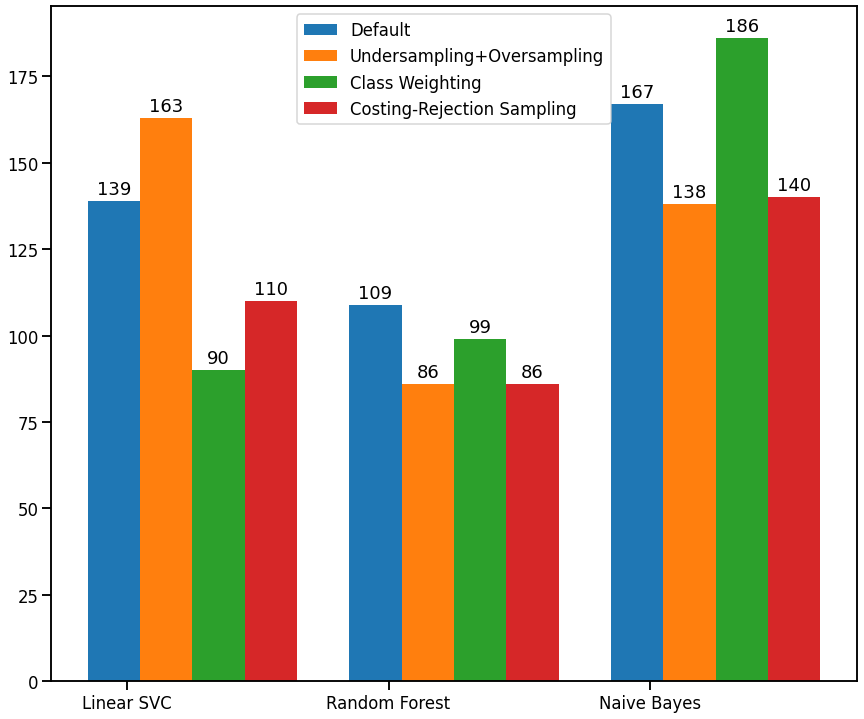

In [24]:
grouped_bar(tolist)